In [2]:
!pip install kaggle


In [3]:
from google.colab import files

# Upload kaggle.json that you downloaded
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d asaniczka/1-3m-linkedin-jobs-and-skills-2024 -p /content/


 99% 1.86G/1.88G [00:21<00:00, 149MB/s]
100% 1.88G/1.88G [00:22<00:00, 91.5MB/s]


In [6]:
!unzip /content/1-3m-linkedin-jobs-and-skills-2024.zip -d /content/

Archive:  /content/1-3m-linkedin-jobs-and-skills-2024.zip
  inflating: /content/job_skills.csv  
  inflating: /content/job_summary.csv  
  inflating: /content/linkedin_job_postings.csv  


In [7]:
import os

# List all files in the current directory
files = os.listdir('/content/')

# Display the list of files
files

['.config',
 'kaggle.json',
 '1-3m-linkedin-jobs-and-skills-2024.zip',
 'job_summary.csv',
 'linkedin_job_postings.csv',
 'job_skills.csv',
 'sample_data']

In [8]:
!ls /content/

1-3m-linkedin-jobs-and-skills-2024.zip	job_summary.csv  linkedin_job_postings.csv
job_skills.csv				kaggle.json	 sample_data


In [9]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5a37fb054fbc19352c85d5f627e2322fe4ac5d38e01c92f519e72270109d89fc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [10]:
!pip install sparknlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 3.6 MB/s eta 0:00:00


In [11]:
import sparknlp
spark = sparknlp.start(memory="32G")

In [12]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

In [13]:
# Initialize Spark session
spark = SparkSession.builder.appName("FrequentItemsets").getOrCreate()

In [14]:
# Update the CSV file path to include the full path to the actual CSV file
csv_file_path = "/content/job_skills.csv"

# Load the CSV file into a PySpark DataFrame
df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csv_file_path)

# Show the first few rows of the DataFrame
df.show(10, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|job_link                                                                                                                       |job_skills                            

In [15]:
# Assuming 'df' is your DataFrame with 'job_skills' column
# Sample a fraction of the data
sampled_df = df.sample(fraction=0.001, seed=42)

In [16]:
from pyspark.sql import functions as F

# Text preprocessing
sampled_df = sampled_df.withColumn("job_skills", F.lower(F.col("job_skills")))  # Convert to lowercase
sampled_df = sampled_df.withColumn("job_skills", F.regexp_replace(F.col("job_skills"), "[^a-zA-Z\\s]", ""))  # Remove non-alphabetic characters

In [17]:
sampled_df.groupBy("job_skills").count().filter("count > 1").show()

+----------+-----+
|job_skills|count|
+----------+-----+
|      NULL|    3|
+----------+-----+



In [18]:
# Filter out rows where 'job_skills' is null using SQL-like syntax
sampled_df = sampled_df.filter("job_skills IS NOT NULL")


In [19]:
# Group by 'job_skills' and count again to verify the removal of nulls
sampled_df.groupBy("job_skills").count().filter("count > 1").show()


+----------+-----+
|job_skills|count|
+----------+-----+
+----------+-----+



In [20]:
from pyspark.ml.feature import Tokenizer

# Tokenize the text into words
tokenizer = Tokenizer(inputCol="job_skills", outputCol="words")
sampled_df = tokenizer.transform(sampled_df)

In [21]:
from pyspark.ml.feature import StopWordsRemover

# Remove stop words
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
sampled_df = stop_words_remover.transform(sampled_df)

In [22]:
# Create a Spark DataFrame with 'transactions' column
transactions_df = sampled_df.select("filtered_words").withColumnRenamed("filtered_words", "transactions")

In [23]:
# Show the first few rows of the DataFrame
transactions_df.show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|transactions                                                                                                                                                                             

In [24]:
from pyspark.ml.feature import StopWordsRemover

# Remove stop words
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words2")
sampled_df = stop_words_remover.transform(sampled_df)

# Additional stop words to remove
additional_stop_words = ["also", "whereas","one" , "two", "three", "four", "five", "six", "seven", "eight", "nine"]

# Define StopWordsRemover for additional stop words
additional_stopwords_remover = StopWordsRemover(
    inputCol="filtered_words2",
    outputCol="final_words",
    stopWords=additional_stop_words
)

# Remove specified additional stop words
sampled_df = additional_stopwords_remover.transform(sampled_df)

# Select the relevant columns
transactions_df = sampled_df.select("final_words").withColumnRenamed("final_words", "transactions")

# Show the result
transactions_df.show(truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|transactions                                                                                                                                                                             

In [25]:
transactions_df.printSchema()


root
 |-- transactions: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [26]:
from pyspark.sql.functions import collect_list


In [27]:
from pyspark.sql.functions import array_distinct
# Show unique transactions before array_distinct
transactions_df.select("transactions").distinct().show(truncate=False)

# Remove duplicate words within each transaction
transactions_df = transactions_df.withColumn("transactions", array_distinct("transactions"))

# Show unique transactions after array_distinct
transactions_df.select("transactions").distinct().show(truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|transactions                                                                                                                                                                                                                         

In [28]:
#partition
numPartitions = 8
transactions_df = transactions_df.repartition(numPartitions)


In [29]:
from pyspark.sql.functions import array_distinct

# 'transactions_df' is my DataFrame with 'transactions' column
transactions_df = transactions_df.withColumn("transactions", array_distinct("transactions"))

# Apply the FPGrowth algorithm
min_support = 0.01  # Adjust as needed
min_confidence = 0.5  # Adjust as needed
fp_growth = FPGrowth(itemsCol="transactions", minSupport=min_support, minConfidence=min_confidence)
model = fp_growth.fit(transactions_df)


In [30]:
# Show frequent itemsets
result = model.freqItemsets
result.show(truncate=False)

+------------------------------------------+----+
|items                                     |freq|
+------------------------------------------+----+
|[parental]                                |16  |
|[parental, leave]                         |16  |
|[reimbursement]                           |41  |
|[reimbursement, insurance]                |22  |
|[reimbursement, vision]                   |15  |
|[reimbursement, vision, insurance]        |15  |
|[reimbursement, employee]                 |16  |
|[reimbursement, professional]             |14  |
|[reimbursement, medical]                  |19  |
|[reimbursement, life]                     |17  |
|[reimbursement, life, insurance]          |16  |
|[reimbursement, k]                        |14  |
|[reimbursement, health]                   |16  |
|[reimbursement, dental]                   |15  |
|[reimbursement, dental, insurance]        |15  |
|[reimbursement, dental, vision]           |15  |
|[reimbursement, dental, vision, insurance]|15  |


In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

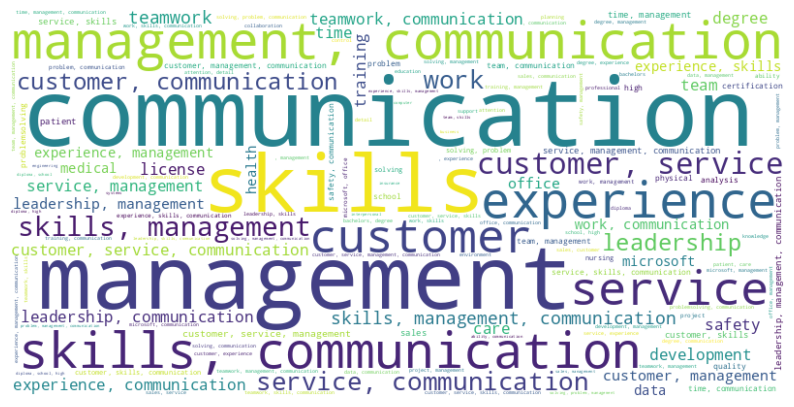

In [32]:
# Create a dictionary for wordcloud
wordcloud_dict = {(tuple(row['items']), row['freq']) for row in result.collect()}

# Convert the set of tuples to a dictionary with concatenated strings
wordcloud_dict = {', '.join(item): freq for item, freq in wordcloud_dict}

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_dict)

# Display the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [33]:
# Display association rules
print("Association Rules:")
model.associationRules.show(truncate=False)

Association Rules:
+---------------------------------------------------------------+----------------+------------------+------------------+--------------------+
|antecedent                                                     |consequent      |confidence        |lift              |support             |
+---------------------------------------------------------------+----------------+------------------+------------------+--------------------+
|[school, high, license, service]                               |[customer]      |1.0               |3.586021505376344 |0.015742128935532233|
|[school, high, license, service]                               |[communication] |0.7619047619047619|1.371634213739477 |0.01199400299850075 |
|[school, high, license, service]                               |[drivers]       |0.9047619047619048|12.977982590885816|0.01424287856071964 |
|[school, high, license, service]                               |[diploma]       |0.9047619047619048|8.683110654333676 |0.0142428